### ECE 763 Project 3 Babysitting the training of DNN

                                                                                   Rachel Hyo Son

In [1]:
import torch
import torchvision
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor,Resize,Normalize
%matplotlib inline
import numpy as np
import os
import torch.nn as nn
import matplotlib.pyplot as plt
import cv2
from time import time

In [2]:
os.getcwd()

'C:\\Users\\Rache\\Documents\\GitHub\\ECE 763\\hson_project03\\00.psudo'

In [3]:
root_dir='./main_dir'

**Using `CIFAR10` dataset to build my model**

In [4]:
import torchvision.transforms as transforms
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [5]:
trainset

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )

In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Assuming that we are on a CUDA machine, this should print a CUDA device:

print(device)

cuda:0


In [7]:
dataiter = iter(trainloader)
images, labels = dataiter.next()

print(images.shape) # batch size , # of channel, # pixelsize, pixel size 
print(labels.shape)

torch.Size([4, 3, 32, 32])
torch.Size([4])


In [8]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

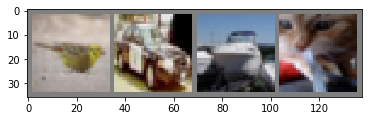

 bird   car  ship   cat


In [9]:
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [10]:
inputSize = 32*32*3
outputSize = 10
hiddenSize = 50

parameter : `requires_grad` want gradients with respect to weights

**pytorch.autograd** provides classes and functions implementing automatic differentiation of arbitrary scalar valued functions. It requires minimal changes to the existing code - you only need to declare Tensor s for which gradients should be computed with the `requires_grad=True` keyword.

In [11]:
W1 = torch.randn(inputSize, hiddenSize, requires_grad=True)
#W1.requires_grad_()
W2 = torch.randn(hiddenSize,outputSize, requires_grad=True)
#W2.requires_grad_()

#### Active Function

In [12]:
from torch.nn import Sigmoid
sigmoid = Sigmoid()

In [13]:
def model_Sigmoid(X):
    z  = torch.matmul(X, W1)
    z2 = sigmoid(z)
    z3 = torch.matmul(z2,W2)
    #o  = sigmoid(z3)
    return z3

Rectified Linear unit (ReLU) are commonly used since they are relatively robust to the vanishing/exploding gradient issues

In [14]:
def model_Relu(X):
    z  = torch.matmul(X, W1)
    z2 = z.clamp(min=0)
    z3 = torch.matmul(z2,W2)
    #o  = sigmoid(z3)
    return z3

#### Loss Function 

- Measures the cross-entropy between the predicted and the actual value. 
- x is the probability of the true label and y is the probability of predicted label 
- cross-entropy as a loss function is used to learn the probability distribution of the data. cross entropy gives a greater penalty when incorrect predictions are predicted with high confidence

In [15]:
criterion = nn.CrossEntropyLoss()

#### Training loop
- `loss.backward()`: updates the gradients of the model (`weight`)
- `with torch.no_grad()`: use gradients to update the `weight`
- `grad.zero_()`: set the gradients to zero, so that get ready for the next


In [16]:
time0 = time()
lr = 0.5 # learning rate
for i, data in enumerate(trainloader, 0):
    running_loss = 0
    # get the inputs; data is a list of [inputs, labels]
    inputs, labels = data
    X = torch.reshape(inputs,(-1,32*32*3))
    x = torch.tensor(X)
    output = model_Sigmoid(x)   
    
    loss = criterion(output,labels)
    loss.backward() ## updates the gradients of the model weights 
    
    running_loss += loss.item()
    with torch.no_grad():
        W1 -=  W1.grad *lr
        W2 -=  W2.grad *lr
        W1.grad.zero_()
        W2.grad.zero_()   
    #print(f' Loss : {running_loss/len(trainloader)}')
#print(f' Training Time : {(time()-time0)/60}')

C:\Users\Rache\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


In [17]:
X.size()

torch.Size([4, 3072])

In [18]:
labels

tensor([2, 2, 6, 3])

#### loop over the dataset multiple times using `epoch`

In [19]:
for epoch in range(3):
    running_loss = 0.0
    lr = 0.5 # learning rate
    for i, data in enumerate(trainloader, 0):
    
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        X = inputs.reshape(-1,32*32*3)
        x = torch.tensor(X)
        output = model_Sigmoid(x)   
    
        loss = criterion(output,labels)
        loss.backward() ## updates the gradients of the model weights 
    
        with torch.no_grad():
            W1 -=  W1.grad *lr
            W2 -=  W2.grad *lr
            W1.grad.zero_()
            W2.grad.zero_()
        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            #print('[%d, %5d] loss: %.3f' %
                 # (epoch + 1, i + 1, running_loss / 2000))
            print(f'Epoch:{epoch+1},loss:{running_loss/2000:.2f}')
            running_loss = 0.0

print('Finished Training')

C:\Users\Rache\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if __name__ == '__main__':


Epoch:1,loss:2.57
Epoch:1,loss:2.53
Epoch:1,loss:2.53
Epoch:1,loss:2.55
Epoch:1,loss:2.50
Epoch:1,loss:2.49
Epoch:2,loss:2.49
Epoch:2,loss:2.48
Epoch:2,loss:2.46
Epoch:2,loss:2.45
Epoch:2,loss:2.41
Epoch:2,loss:2.44
Epoch:3,loss:2.43
Epoch:3,loss:2.41
Epoch:3,loss:2.45
Epoch:3,loss:2.41
Epoch:3,loss:2.42
Epoch:3,loss:2.43
Finished Training


####  Model-1: activation function with Sigmoid

In [20]:
inputSize = 32*32*3
outputSize = 10
hiddenSize_1 = 100

In [21]:
model = torch.nn.Sequential(
    torch.nn.Linear(inputSize,hiddenSize),
    torch.nn.Sigmoid(),
    torch.nn.Linear(hiddenSize,outputSize))
print(model)

Sequential(
  (0): Linear(in_features=3072, out_features=50, bias=True)
  (1): Sigmoid()
  (2): Linear(in_features=50, out_features=10, bias=True)
)


In [22]:
for epoch in range(2): 
    learning_rate = 1e-2
    momentum = 0
    optimizer = torch.optim.SGD(model.parameters(),lr=learning_rate, momentum=momentum)
    
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        X = inputs.reshape(-1,32*32*3)
        x = torch.tensor(X)
        y_pred = model(x)
        loss = criterion(y_pred,labels)
    
        loss.backward()
    
        optimizer.step()
        optimizer.zero_grad()
        
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

C:\Users\Rache\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # Remove the CWD from sys.path while we load stuff.


[1,  2000] loss: 2.049
[1,  4000] loss: 1.853
[1,  6000] loss: 1.812
[1,  8000] loss: 1.773
[1, 10000] loss: 1.743
[1, 12000] loss: 1.733
[2,  2000] loss: 1.704
[2,  4000] loss: 1.674
[2,  6000] loss: 1.675
[2,  8000] loss: 1.670
[2, 10000] loss: 1.674
[2, 12000] loss: 1.675
Finished Training


In [23]:
#train score
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        X = images.reshape(-1,32*32*3)
        outputs = model(X)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 42 %


In [24]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        X = images.reshape(-1,32*32*3)
        outputs = model(X)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 57 %
Accuracy of   car : 46 %
Accuracy of  bird : 22 %
Accuracy of   cat : 17 %
Accuracy of  deer : 33 %
Accuracy of   dog : 36 %
Accuracy of  frog : 58 %
Accuracy of horse : 45 %
Accuracy of  ship : 51 %
Accuracy of truck : 57 %


#### Model-2 : activation function with ReLu (one-layer)

In [25]:
inputSize = 32*32*3
outputSize = 10
hiddenSize = 100

In [26]:
from torch import nn
model = torch.nn.Sequential(
    torch.nn.Linear(inputSize,hiddenSize),
    torch.nn.ReLU(),
    torch.nn.Linear(hiddenSize,outputSize),
    torch.nn.LogSoftmax(dim=1))
print(model)

Sequential(
  (0): Linear(in_features=3072, out_features=100, bias=True)
  (1): ReLU()
  (2): Linear(in_features=100, out_features=10, bias=True)
  (3): LogSoftmax()
)


In [27]:
for epoch in range(2): 
    learning_rate = 1e-2
    momentum = 0
    optimizer = torch.optim.SGD(model.parameters(),lr=learning_rate, momentum=momentum)
    
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        X = inputs.reshape(-1,32*32*3)
        x = torch.tensor(X)
        y_pred = model(x)
        loss = criterion(y_pred,labels)
    
        loss.backward()
    
        optimizer.step()
        optimizer.zero_grad()
        
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

C:\Users\Rache\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # Remove the CWD from sys.path while we load stuff.


[1,  2000] loss: 1.840
[1,  4000] loss: 1.696
[1,  6000] loss: 1.657
[1,  8000] loss: 1.627
[1, 10000] loss: 1.625
[1, 12000] loss: 1.580
[2,  2000] loss: 1.510
[2,  4000] loss: 1.516
[2,  6000] loss: 1.504
[2,  8000] loss: 1.523
[2, 10000] loss: 1.495
[2, 12000] loss: 1.499
Finished Training


In [28]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        X = images.reshape(-1,32*32*3)
        outputs = model(X)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 46 %


In [29]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        X = images.reshape(-1,32*32*3)
        outputs = model(X)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 26 %
Accuracy of   car : 62 %
Accuracy of  bird : 42 %
Accuracy of   cat : 15 %
Accuracy of  deer : 31 %
Accuracy of   dog : 36 %
Accuracy of  frog : 66 %
Accuracy of horse : 60 %
Accuracy of  ship : 69 %
Accuracy of truck : 53 %


#### Model -2 : activation function with ReLu

In [63]:
from torch import nn
model = torch.nn.Sequential(
    torch.nn.Linear(inputSize,hiddenSize),
    torch.nn.ReLU(),
    torch.nn.Linear(hiddenSize,outputSize),
    torch.nn.LogSoftmax(dim=1))
print(model)

Sequential(
  (0): Linear(in_features=3072, out_features=100, bias=True)
  (1): ReLU()
  (2): Linear(in_features=100, out_features=10, bias=True)
  (3): LogSoftmax()
)


#### loop over the dataset multiple times using `epoch`

### Learning Rate 

 `learning rate` is 1e-2

In [31]:
for epoch in range(2): 
    learning_rate = 1e-2
    
    optimizer = torch.optim.SGD(model.parameters(),lr=learning_rate)
    
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        X = inputs.reshape(-1,32*32*3)
        x = torch.tensor(X)
        y_pred = model(x)
        loss = criterion(y_pred,labels)
    
        loss.backward()
    
        optimizer.step()
        optimizer.zero_grad()
        
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

C:\Users\Rache\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # Remove the CWD from sys.path while we load stuff.


[1,  2000] loss: 1.848
[1,  4000] loss: 1.696
[1,  6000] loss: 1.661
[1,  8000] loss: 1.634
[1, 10000] loss: 1.595
[1, 12000] loss: 1.594
[2,  2000] loss: 1.520
[2,  4000] loss: 1.512
[2,  6000] loss: 1.529
[2,  8000] loss: 1.498
[2, 10000] loss: 1.523
[2, 12000] loss: 1.479
Finished Training


In [32]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        X = images.reshape(-1,32*32*3)
        outputs = model(X)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 47 %


In [33]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        X = images.reshape(-1,32*32*3)
        outputs = model(X)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 49 %
Accuracy of   car : 50 %
Accuracy of  bird : 26 %
Accuracy of   cat : 44 %
Accuracy of  deer : 47 %
Accuracy of   dog : 29 %
Accuracy of  frog : 54 %
Accuracy of horse : 61 %
Accuracy of  ship : 66 %
Accuracy of truck : 50 %


 `learning rate` change to 1e-3

In [34]:
for epoch in range(2): 
    learning_rate = 1e-3
    momentum = 0
    optimizer = torch.optim.SGD(model.parameters(),lr=learning_rate, momentum=momentum)
    
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        X = inputs.reshape(-1,32*32*3)
        x = torch.tensor(X)
        y_pred = model(x)
        loss = criterion(y_pred,labels)
    
        loss.backward()
    
        optimizer.step()
        optimizer.zero_grad()
        
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

C:\Users\Rache\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # Remove the CWD from sys.path while we load stuff.


[1,  2000] loss: 1.308
[1,  4000] loss: 1.282
[1,  6000] loss: 1.279
[1,  8000] loss: 1.274
[1, 10000] loss: 1.246
[1, 12000] loss: 1.275
[2,  2000] loss: 1.238
[2,  4000] loss: 1.238
[2,  6000] loss: 1.251
[2,  8000] loss: 1.239
[2, 10000] loss: 1.229
[2, 12000] loss: 1.220
Finished Training


Loss is reasonably changing

In [35]:
#PATH = './cifar_net.pth'
#torch.save(model.state_dict(), PATH)

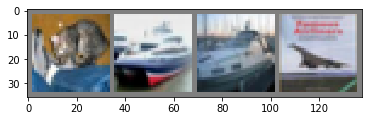

GroundTruth:    cat  ship  ship plane


In [36]:
dataiter = iter(testloader)
images, labels = dataiter.next()

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [37]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        X = images.reshape(-1,32*32*3)
        outputs = model(X)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 52 %


In [38]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        X = images.reshape(-1,32*32*3)
        outputs = model(X)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 57 %
Accuracy of   car : 62 %
Accuracy of  bird : 33 %
Accuracy of   cat : 31 %
Accuracy of  deer : 42 %
Accuracy of   dog : 42 %
Accuracy of  frog : 69 %
Accuracy of horse : 60 %
Accuracy of  ship : 67 %
Accuracy of truck : 57 %


 `learning rate` change to 1e-6

In [39]:
for epoch in range(2): 
    learning_rate =1e-6
    optimizer = torch.optim.SGD(model.parameters(),lr=learning_rate)
    
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        X = inputs.reshape(-1,32*32*3)
        x = torch.tensor(X)
        y_pred = model(x)
        loss = criterion(y_pred,labels)
    
        loss.backward()
    
        optimizer.step()
        optimizer.zero_grad()
        
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

C:\Users\Rache\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if __name__ == '__main__':


[1,  2000] loss: 1.197
[1,  4000] loss: 1.216
[1,  6000] loss: 1.181
[1,  8000] loss: 1.215
[1, 10000] loss: 1.200
[1, 12000] loss: 1.221
[2,  2000] loss: 1.203
[2,  4000] loss: 1.189
[2,  6000] loss: 1.210
[2,  8000] loss: 1.199
[2, 10000] loss: 1.205
[2, 12000] loss: 1.211
Finished Training


In [40]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        X = images.reshape(-1,32*32*3)
        outputs = model(X)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 52 %


In [41]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        X = images.reshape(-1,32*32*3)
        outputs = model(X)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 57 %
Accuracy of   car : 62 %
Accuracy of  bird : 33 %
Accuracy of   cat : 31 %
Accuracy of  deer : 43 %
Accuracy of   dog : 42 %
Accuracy of  frog : 68 %
Accuracy of horse : 60 %
Accuracy of  ship : 68 %
Accuracy of truck : 57 %


 `learning rate` change to 1e-4

In [42]:
for epoch in range(2): 
    learning_rate =1e-4
    optimizer = torch.optim.SGD(model.parameters(),lr=learning_rate)
    
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        X = inputs.reshape(-1,32*32*3)
        x = torch.tensor(X)
        y_pred = model(x)
        loss = criterion(y_pred,labels)
    
        loss.backward()
    
        optimizer.step()
        optimizer.zero_grad()
        
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

C:\Users\Rache\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if __name__ == '__main__':


[1,  2000] loss: 1.208
[1,  4000] loss: 1.207
[1,  6000] loss: 1.192
[1,  8000] loss: 1.203
[1, 10000] loss: 1.194
[1, 12000] loss: 1.194
[2,  2000] loss: 1.191
[2,  4000] loss: 1.201
[2,  6000] loss: 1.202
[2,  8000] loss: 1.188
[2, 10000] loss: 1.200
[2, 12000] loss: 1.181
Finished Training


In [43]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        X = images.reshape(-1,32*32*3)
        outputs = model(X)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 52 %


In [44]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        X = images.reshape(-1,32*32*3)
        outputs = model(X)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 57 %
Accuracy of   car : 61 %
Accuracy of  bird : 38 %
Accuracy of   cat : 33 %
Accuracy of  deer : 45 %
Accuracy of   dog : 36 %
Accuracy of  frog : 65 %
Accuracy of horse : 60 %
Accuracy of  ship : 67 %
Accuracy of truck : 60 %


`learning rate` change to 1e-5

In [45]:
for epoch in range(2): 
    learning_rate =1e-5
    optimizer = torch.optim.SGD(model.parameters(),lr=learning_rate)
    
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        X = inputs.reshape(-1,32*32*3)
        x = torch.tensor(X)
        y_pred = model(x)
        loss = criterion(y_pred,labels)
    
        loss.backward()
    
        optimizer.step()
        optimizer.zero_grad()
        
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

C:\Users\Rache\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if __name__ == '__main__':


[1,  2000] loss: 1.188
[1,  4000] loss: 1.216
[1,  6000] loss: 1.183
[1,  8000] loss: 1.194
[1, 10000] loss: 1.190
[1, 12000] loss: 1.179
[2,  2000] loss: 1.182
[2,  4000] loss: 1.188
[2,  6000] loss: 1.203
[2,  8000] loss: 1.195
[2, 10000] loss: 1.188
[2, 12000] loss: 1.189
Finished Training


In [46]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        X = images.reshape(-1,32*32*3)
        outputs = model(X)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 52 %


In [47]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        X = images.reshape(-1,32*32*3)
        outputs = model(X)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 57 %
Accuracy of   car : 61 %
Accuracy of  bird : 37 %
Accuracy of   cat : 32 %
Accuracy of  deer : 45 %
Accuracy of   dog : 38 %
Accuracy of  frog : 65 %
Accuracy of horse : 60 %
Accuracy of  ship : 68 %
Accuracy of truck : 59 %


 `learning rate` is selected `1e-3`

- Regularization : weight_decay = 1e-5

In [48]:
for epoch in range(2): 
    learning_rate =1e-3
    optimizer = torch.optim.SGD(model.parameters(),lr=learning_rate,weight_decay=1e-5)
    
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        X = inputs.reshape(-1,32*32*3)
        x = torch.tensor(X)
        y_pred = model(x)
        loss = criterion(y_pred,labels)
    
        loss.backward()
    
        optimizer.step()
        optimizer.zero_grad()
        
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

C:\Users\Rache\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if __name__ == '__main__':


[1,  2000] loss: 1.202
[1,  4000] loss: 1.211
[1,  6000] loss: 1.198
[1,  8000] loss: 1.214
[1, 10000] loss: 1.217
[1, 12000] loss: 1.204
[2,  2000] loss: 1.180
[2,  4000] loss: 1.192
[2,  6000] loss: 1.196
[2,  8000] loss: 1.187
[2, 10000] loss: 1.210
[2, 12000] loss: 1.188
Finished Training


In [49]:
#train score
correct = 0
total = 0
with torch.no_grad():
    for data in trainloader:
        images, labels = data
        X = images.reshape(-1,32*32*3)
        outputs = model(X)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
print('Accuracy of the network on the train images: %d %%' % (100 * correct / total))

Accuracy of the network on the train images: 59 %


In [50]:
#test score
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        X = images.reshape(-1,32*32*3)
        outputs = model(X)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 52 %


In [51]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        X = images.reshape(-1,32*32*3)
        outputs = model(X)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 61 %
Accuracy of   car : 58 %
Accuracy of  bird : 35 %
Accuracy of   cat : 30 %
Accuracy of  deer : 49 %
Accuracy of   dog : 45 %
Accuracy of  frog : 59 %
Accuracy of horse : 59 %
Accuracy of  ship : 65 %
Accuracy of truck : 62 %


 `loss rate` is selected `1e-3`

- Regularization : weight_decay = 1e-6

In [52]:
for epoch in range(2): 
    learning_rate =1e-3
    optimizer = torch.optim.SGD(model.parameters(),lr=learning_rate,weight_decay=1e-6)
    
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        X = inputs.reshape(-1,32*32*3)
        x = torch.tensor(X)
        y_pred = model(x)
        loss = criterion(y_pred,labels)
    
        loss.backward()
    
        optimizer.step()
        optimizer.zero_grad()
        
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

C:\Users\Rache\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if __name__ == '__main__':


[1,  2000] loss: 1.173
[1,  4000] loss: 1.164
[1,  6000] loss: 1.168
[1,  8000] loss: 1.154
[1, 10000] loss: 1.186
[1, 12000] loss: 1.195
[2,  2000] loss: 1.145
[2,  4000] loss: 1.160
[2,  6000] loss: 1.161
[2,  8000] loss: 1.175
[2, 10000] loss: 1.149
[2, 12000] loss: 1.157
Finished Training


In [53]:
# training data result
correct = 0
total = 0
with torch.no_grad():
    for data in trainloader:
        images, labels = data
        X = images.reshape(-1,32*32*3)
        outputs = model(X)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
print('Accuracy of the network on the train images: %d %%' % (100 * correct / total))

Accuracy of the network on the train images: 61 %


In [54]:
# testing data accuracy
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        X = images.reshape(-1,32*32*3)
        outputs = model(X)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 53 %


In [55]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        X = images.reshape(-1,32*32*3)
        outputs = model(X)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 56 %
Accuracy of   car : 60 %
Accuracy of  bird : 38 %
Accuracy of   cat : 31 %
Accuracy of  deer : 45 %
Accuracy of   dog : 44 %
Accuracy of  frog : 66 %
Accuracy of horse : 60 %
Accuracy of  ship : 70 %
Accuracy of truck : 58 %


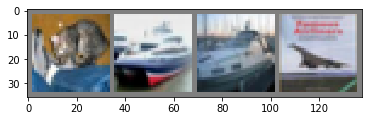

GroundTruth:    cat  ship  ship plane


In [56]:
dataiter = iter(testloader)
images, labels = dataiter.next()

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

#### Momentum 

In [57]:
for epoch in range(2): 
    learning_rate =1e-3
    optimizer = torch.optim.SGD(model.parameters(),lr=learning_rate,weight_decay=1e-5, momentum=0.001)
    
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        X = inputs.reshape(-1,32*32*3)
        x = torch.tensor(X)
        y_pred = model(x)
        loss = criterion(y_pred,labels)
    
        loss.backward()
    
        optimizer.step()
        optimizer.zero_grad()
        
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

C:\Users\Rache\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if __name__ == '__main__':


[1,  2000] loss: 1.145
[1,  4000] loss: 1.144
[1,  6000] loss: 1.133
[1,  8000] loss: 1.129
[1, 10000] loss: 1.160
[1, 12000] loss: 1.148
[2,  2000] loss: 1.119
[2,  4000] loss: 1.113
[2,  6000] loss: 1.142
[2,  8000] loss: 1.134
[2, 10000] loss: 1.123
[2, 12000] loss: 1.140
Finished Training


In [58]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        X = images.reshape(-1,32*32*3)
        outputs = model(X)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 52 %


In [59]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        X = images.reshape(-1,32*32*3)
        outputs = model(X)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 61 %
Accuracy of   car : 59 %
Accuracy of  bird : 35 %
Accuracy of   cat : 31 %
Accuracy of  deer : 49 %
Accuracy of   dog : 37 %
Accuracy of  frog : 66 %
Accuracy of horse : 60 %
Accuracy of  ship : 65 %
Accuracy of truck : 58 %


### Hyperparameter Optimization

In [65]:
max_count = 100 
for count in range(max_count):
    weight_decay = 10**np.random.uniform(-6,-3)
    learning_rate = 10**np.random.uniform(-5,-3)
    
    for epoch in range(2): 
        optimizer = torch.optim.SGD(model.parameters(),lr=learning_rate,weight_decay=weight_decay)
    
        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            inputs, labels = data
            X = inputs.reshape(-1,32*32*3)
            x = torch.tensor(X)
            y_pred = model(x)
            loss = criterion(y_pred,labels)
    
            loss.backward()
    
            optimizer.step()
            optimizer.zero_grad()
        
            running_loss += loss.item()
            if i % 2000 == 1999:    # print every 2000 mini-batches
                correct = 0
                total = 0
                with torch.no_grad():
                    for data in testloader:
                        images, labels = data
                        X = images.reshape(-1,32*32*3)
                        outputs = model(X)
                        _, predicted = torch.max(outputs.data, 1)
                        total += labels.size(0)
                        correct += (predicted == labels).sum().item()
                print(f'count : {count+1} | epoch : {epoch+1} batch: {i+1} lr : {learning_rate:.6f} wd: {weight_decay:.6f}, loss: {running_loss/2000:.2f} accuracy: {100 * (correct / total):.2f}')
                running_loss = 0.0

print('Finished Training')
    

C:\Users\Rache\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  del sys.path[0]


count : 1 | epoch : 1 batch: 2000 lr : 0.000069 wd: 0.000173, loss: 2.28 accuracy: 18.91
count : 1 | epoch : 1 batch: 4000 lr : 0.000069 wd: 0.000173, loss: 2.23 accuracy: 24.18
count : 1 | epoch : 1 batch: 6000 lr : 0.000069 wd: 0.000173, loss: 2.19 accuracy: 25.93
count : 1 | epoch : 1 batch: 8000 lr : 0.000069 wd: 0.000173, loss: 2.16 accuracy: 27.08
count : 1 | epoch : 1 batch: 10000 lr : 0.000069 wd: 0.000173, loss: 2.13 accuracy: 28.10
count : 1 | epoch : 1 batch: 12000 lr : 0.000069 wd: 0.000173, loss: 2.10 accuracy: 28.91
count : 1 | epoch : 2 batch: 2000 lr : 0.000069 wd: 0.000173, loss: 2.07 accuracy: 30.14
count : 1 | epoch : 2 batch: 4000 lr : 0.000069 wd: 0.000173, loss: 2.05 accuracy: 30.78
count : 1 | epoch : 2 batch: 6000 lr : 0.000069 wd: 0.000173, loss: 2.03 accuracy: 31.30
count : 1 | epoch : 2 batch: 8000 lr : 0.000069 wd: 0.000173, loss: 2.01 accuracy: 31.60
count : 1 | epoch : 2 batch: 10000 lr : 0.000069 wd: 0.000173, loss: 1.99 accuracy: 32.06
count : 1 | epoch 

count : 16 | epoch : 1 batch: 4000 lr : 0.000013 wd: 0.000206, loss: 1.28 accuracy: 50.73
count : 16 | epoch : 1 batch: 6000 lr : 0.000013 wd: 0.000206, loss: 1.30 accuracy: 50.73
count : 16 | epoch : 1 batch: 8000 lr : 0.000013 wd: 0.000206, loss: 1.32 accuracy: 50.74
count : 16 | epoch : 1 batch: 10000 lr : 0.000013 wd: 0.000206, loss: 1.30 accuracy: 50.77
count : 16 | epoch : 1 batch: 12000 lr : 0.000013 wd: 0.000206, loss: 1.31 accuracy: 50.89
count : 16 | epoch : 2 batch: 2000 lr : 0.000013 wd: 0.000206, loss: 1.30 accuracy: 50.84
count : 16 | epoch : 2 batch: 4000 lr : 0.000013 wd: 0.000206, loss: 1.30 accuracy: 50.92
count : 16 | epoch : 2 batch: 6000 lr : 0.000013 wd: 0.000206, loss: 1.29 accuracy: 50.92
count : 16 | epoch : 2 batch: 8000 lr : 0.000013 wd: 0.000206, loss: 1.30 accuracy: 50.85
count : 16 | epoch : 2 batch: 10000 lr : 0.000013 wd: 0.000206, loss: 1.29 accuracy: 50.91
count : 16 | epoch : 2 batch: 12000 lr : 0.000013 wd: 0.000206, loss: 1.31 accuracy: 51.03
count 

count : 31 | epoch : 1 batch: 4000 lr : 0.000633 wd: 0.000006, loss: 1.09 accuracy: 52.13
count : 31 | epoch : 1 batch: 6000 lr : 0.000633 wd: 0.000006, loss: 1.13 accuracy: 51.92
count : 31 | epoch : 1 batch: 8000 lr : 0.000633 wd: 0.000006, loss: 1.10 accuracy: 51.81
count : 31 | epoch : 1 batch: 10000 lr : 0.000633 wd: 0.000006, loss: 1.10 accuracy: 51.97
count : 31 | epoch : 1 batch: 12000 lr : 0.000633 wd: 0.000006, loss: 1.12 accuracy: 52.50
count : 31 | epoch : 2 batch: 2000 lr : 0.000633 wd: 0.000006, loss: 1.06 accuracy: 51.89
count : 31 | epoch : 2 batch: 4000 lr : 0.000633 wd: 0.000006, loss: 1.09 accuracy: 51.83
count : 31 | epoch : 2 batch: 6000 lr : 0.000633 wd: 0.000006, loss: 1.11 accuracy: 52.11
count : 31 | epoch : 2 batch: 8000 lr : 0.000633 wd: 0.000006, loss: 1.10 accuracy: 51.73
count : 31 | epoch : 2 batch: 10000 lr : 0.000633 wd: 0.000006, loss: 1.10 accuracy: 51.91
count : 31 | epoch : 2 batch: 12000 lr : 0.000633 wd: 0.000006, loss: 1.10 accuracy: 52.30
count 

count : 46 | epoch : 1 batch: 4000 lr : 0.000662 wd: 0.000005, loss: 0.96 accuracy: 51.68
count : 46 | epoch : 1 batch: 6000 lr : 0.000662 wd: 0.000005, loss: 0.95 accuracy: 52.31
count : 46 | epoch : 1 batch: 8000 lr : 0.000662 wd: 0.000005, loss: 0.96 accuracy: 51.99
count : 46 | epoch : 1 batch: 10000 lr : 0.000662 wd: 0.000005, loss: 0.97 accuracy: 51.65
count : 46 | epoch : 1 batch: 12000 lr : 0.000662 wd: 0.000005, loss: 0.96 accuracy: 51.71
count : 46 | epoch : 2 batch: 2000 lr : 0.000662 wd: 0.000005, loss: 0.94 accuracy: 51.80
count : 46 | epoch : 2 batch: 4000 lr : 0.000662 wd: 0.000005, loss: 0.94 accuracy: 51.10
count : 46 | epoch : 2 batch: 6000 lr : 0.000662 wd: 0.000005, loss: 0.96 accuracy: 51.59
count : 46 | epoch : 2 batch: 8000 lr : 0.000662 wd: 0.000005, loss: 0.93 accuracy: 51.91
count : 46 | epoch : 2 batch: 10000 lr : 0.000662 wd: 0.000005, loss: 0.97 accuracy: 51.53
count : 46 | epoch : 2 batch: 12000 lr : 0.000662 wd: 0.000005, loss: 0.96 accuracy: 51.32
count 

count : 61 | epoch : 1 batch: 4000 lr : 0.000027 wd: 0.000601, loss: 0.81 accuracy: 51.71
count : 61 | epoch : 1 batch: 6000 lr : 0.000027 wd: 0.000601, loss: 0.81 accuracy: 51.81
count : 61 | epoch : 1 batch: 8000 lr : 0.000027 wd: 0.000601, loss: 0.80 accuracy: 51.73
count : 61 | epoch : 1 batch: 10000 lr : 0.000027 wd: 0.000601, loss: 0.79 accuracy: 51.79
count : 61 | epoch : 1 batch: 12000 lr : 0.000027 wd: 0.000601, loss: 0.82 accuracy: 51.58
count : 61 | epoch : 2 batch: 2000 lr : 0.000027 wd: 0.000601, loss: 0.82 accuracy: 51.70
count : 61 | epoch : 2 batch: 4000 lr : 0.000027 wd: 0.000601, loss: 0.80 accuracy: 51.63
count : 61 | epoch : 2 batch: 6000 lr : 0.000027 wd: 0.000601, loss: 0.81 accuracy: 51.81
count : 61 | epoch : 2 batch: 8000 lr : 0.000027 wd: 0.000601, loss: 0.81 accuracy: 51.56
count : 61 | epoch : 2 batch: 10000 lr : 0.000027 wd: 0.000601, loss: 0.79 accuracy: 51.70
count : 61 | epoch : 2 batch: 12000 lr : 0.000027 wd: 0.000601, loss: 0.79 accuracy: 51.75
count 

count : 76 | epoch : 1 batch: 4000 lr : 0.000026 wd: 0.000202, loss: 0.72 accuracy: 51.29
count : 76 | epoch : 1 batch: 6000 lr : 0.000026 wd: 0.000202, loss: 0.74 accuracy: 51.41
count : 76 | epoch : 1 batch: 8000 lr : 0.000026 wd: 0.000202, loss: 0.74 accuracy: 51.40
count : 76 | epoch : 1 batch: 10000 lr : 0.000026 wd: 0.000202, loss: 0.74 accuracy: 51.49
count : 76 | epoch : 1 batch: 12000 lr : 0.000026 wd: 0.000202, loss: 0.73 accuracy: 51.38
count : 76 | epoch : 2 batch: 2000 lr : 0.000026 wd: 0.000202, loss: 0.74 accuracy: 51.29
count : 76 | epoch : 2 batch: 4000 lr : 0.000026 wd: 0.000202, loss: 0.73 accuracy: 51.46
count : 76 | epoch : 2 batch: 6000 lr : 0.000026 wd: 0.000202, loss: 0.72 accuracy: 51.50
count : 76 | epoch : 2 batch: 8000 lr : 0.000026 wd: 0.000202, loss: 0.72 accuracy: 51.49
count : 76 | epoch : 2 batch: 10000 lr : 0.000026 wd: 0.000202, loss: 0.75 accuracy: 51.39
count : 76 | epoch : 2 batch: 12000 lr : 0.000026 wd: 0.000202, loss: 0.73 accuracy: 51.29
count 

count : 91 | epoch : 1 batch: 4000 lr : 0.000013 wd: 0.000013, loss: 0.63 accuracy: 50.84
count : 91 | epoch : 1 batch: 6000 lr : 0.000013 wd: 0.000013, loss: 0.66 accuracy: 50.84
count : 91 | epoch : 1 batch: 8000 lr : 0.000013 wd: 0.000013, loss: 0.66 accuracy: 50.79
count : 91 | epoch : 1 batch: 10000 lr : 0.000013 wd: 0.000013, loss: 0.64 accuracy: 50.93
count : 91 | epoch : 1 batch: 12000 lr : 0.000013 wd: 0.000013, loss: 0.62 accuracy: 50.87
count : 91 | epoch : 2 batch: 2000 lr : 0.000013 wd: 0.000013, loss: 0.63 accuracy: 50.86
count : 91 | epoch : 2 batch: 4000 lr : 0.000013 wd: 0.000013, loss: 0.64 accuracy: 50.81
count : 91 | epoch : 2 batch: 6000 lr : 0.000013 wd: 0.000013, loss: 0.64 accuracy: 50.88
count : 91 | epoch : 2 batch: 8000 lr : 0.000013 wd: 0.000013, loss: 0.65 accuracy: 50.80
count : 91 | epoch : 2 batch: 10000 lr : 0.000013 wd: 0.000013, loss: 0.64 accuracy: 50.96
count : 91 | epoch : 2 batch: 12000 lr : 0.000013 wd: 0.000013, loss: 0.65 accuracy: 50.92
count 

- count : 17 | epoch : 1 batch: 4000 lr : 0.000008 wd: 0.000640, loss: 1.07 accuracy: 54.21
- count : 37 | epoch : 2 batch: 4000 lr : 0.000007 wd: 0.000441, loss: 1.06 accuracy: 54.21
- count : 44 | epoch : 2 batch: 4000 lr : 0.000006 wd: 0.003821, loss: 1.08 accuracy: 54.22 
- count : 47 | epoch : 2 batch: 4000 lr : 0.000007 wd: 0.000411, loss: 1.08 accuracy: 54.21
- count : 63 | epoch : 1 batch: 10000 lr : 0.000003 wd: 0.000003, loss: 1.08 accuracy: 54.24
- count : 64 | epoch : 1 batch: 2000 lr : 0.000003 wd: 0.000014, loss: 1.06 accuracy: 54.20
- count : 67 | epoch : 1 batch: 10000 lr : 0.000009 wd: 0.000362, loss: 1.07 accuracy: 54.21
- count : 68 | epoch : 2 batch: 8000 lr : 0.000004 wd: 0.000131, loss: 1.08 accuracy: 54.20
- count : 76 | epoch : 1 batch: 4000 lr : 0.000004 wd: 0.000390, loss: 1.05 accuracy: 54.22
- count : 80 | epoch : 2 batch: 12000 lr : 0.000004 wd: 0.000084, loss: 1.07 accuracy: 54.22
- count : 82 | epoch : 1 batch: 4000 lr : 0.000006 wd: 0.000178, loss: 1.05 accuracy: 54.24
- count : 82 | epoch : 2 batch: 8000 lr : 0.000006 wd: 0.000178, loss: 1.06 accuracy: 54.21
- count : 87 | epoch : 2 batch: 10000 lr : 0.000003 wd: 0.000281, loss: 1.05 accuracy: 54.20
- count : 88 | epoch : 2 batch: 2000 lr : 0.000006 wd: 0.000006, loss: 1.06 accuracy: 54.27
- count : 89 | epoch : 1 batch: 8000 lr : 0.000004 wd: 0.000928, loss: 1.05 accuracy: 54.26
- count : 90 | epoch : 1 batch: 6000 lr : 0.000002 wd: 0.001040, loss: 1.07 accuracy: 54.22
- count : 91 | epoch : 1 batch: 4000 lr : 0.000001 wd: 0.000007, loss: 1.06 accuracy: 54.20
- count : 92 | epoch : 2 batch: 6000 lr : 0.000010 wd: 0.000060, loss: 1.07 accuracy: 54.25
- count : 93 | epoch : 1 batch: 10000 lr : 0.000002 wd: 0.000021, loss: 1.06 accuracy: 54.25
- count : 94 | epoch : 1 batch: 8000 lr : 0.000006 wd: 0.004167, loss: 1.07 accuracy: 54.25
- count : 95 | epoch : 1 batch: 8000 lr : 0.000001 wd: 0.000357, loss: 1.08 accuracy: 54.23

within the range of previous coarse range of learning rate and weight decay, the result of hyperparameter optimization is pertaining low value in loss and promising accuracy.  

In [66]:
for epoch in range(2): 
    learning_rate =6e-6
    optimizer = torch.optim.SGD(model.parameters(),lr=learning_rate,weight_decay=0.004167)
    
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        X = inputs.reshape(-1,32*32*3)
        x = torch.tensor(X)
        y_pred = model(x)
        loss = criterion(y_pred,labels)
    
        loss.backward()
    
        optimizer.step()
        optimizer.zero_grad()
        
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

C:\Users\Rache\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if __name__ == '__main__':


[1,  2000] loss: 0.608
[1,  4000] loss: 0.597
[1,  6000] loss: 0.612
[1,  8000] loss: 0.604
[1, 10000] loss: 0.594
[1, 12000] loss: 0.607
[2,  2000] loss: 0.611
[2,  4000] loss: 0.598
[2,  6000] loss: 0.609
[2,  8000] loss: 0.598
[2, 10000] loss: 0.608
[2, 12000] loss: 0.603
Finished Training


In [67]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        X = images.reshape(-1,32*32*3)
        outputs = model(X)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 50 %


In [68]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        X = images.reshape(-1,32*32*3)
        outputs = model(X)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 56 %
Accuracy of   car : 57 %
Accuracy of  bird : 40 %
Accuracy of   cat : 35 %
Accuracy of  deer : 44 %
Accuracy of   dog : 39 %
Accuracy of  frog : 56 %
Accuracy of horse : 55 %
Accuracy of  ship : 66 %
Accuracy of truck : 54 %


learning_rate =1e-3 weight_decay = 1e-6

In [69]:
for epoch in range(2): 
    learning_rate =1e-3
    optimizer = torch.optim.SGD(model.parameters(),lr=learning_rate,weight_decay=1e-6)
    
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        X = inputs.reshape(-1,32*32*3)
        x = torch.tensor(X)
        y_pred = model(x)
        loss = criterion(y_pred,labels)
    
        loss.backward()
    
        optimizer.step()
        optimizer.zero_grad()
        
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

C:\Users\Rache\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if __name__ == '__main__':


[1,  2000] loss: 0.709
[1,  4000] loss: 0.730
[1,  6000] loss: 0.751
[1,  8000] loss: 0.751
[1, 10000] loss: 0.775
[1, 12000] loss: 0.760
[2,  2000] loss: 0.698
[2,  4000] loss: 0.743
[2,  6000] loss: 0.741
[2,  8000] loss: 0.756
[2, 10000] loss: 0.760
[2, 12000] loss: 0.756
Finished Training


In [70]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        X = images.reshape(-1,32*32*3)
        outputs = model(X)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 49 %


In [71]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        X = images.reshape(-1,32*32*3)
        outputs = model(X)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 52 %
Accuracy of   car : 60 %
Accuracy of  bird : 39 %
Accuracy of   cat : 34 %
Accuracy of  deer : 50 %
Accuracy of   dog : 33 %
Accuracy of  frog : 52 %
Accuracy of horse : 54 %
Accuracy of  ship : 64 %
Accuracy of truck : 49 %


### Face Data 

In [4]:
root_dir='./main_dir'

In [5]:
from torchvision import transforms
transforms = transforms.Compose([Resize((32,32)),
                                 ToTensor(),
                                 Normalize([0.485,0.456,0.406],[0.229,0.2245,0.225])])

In [6]:
trainset = torchvision.datasets.ImageFolder(root=os.path.join(root_dir,'train_dir'),
                                            transform=transforms)

In [7]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

In [8]:
testset = torchvision.datasets.ImageFolder(root=os.path.join(root_dir,'test_dir'), 
                                           transform=transforms)

In [9]:
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

In [10]:
classes = ('face','nonface')

In [11]:
trainset

Dataset ImageFolder
    Number of datapoints: 2000
    Root location: ./main_dir\train_dir
    StandardTransform
Transform: Compose(
               Resize(size=(32, 32), interpolation=PIL.Image.BILINEAR)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.2245, 0.225])
           )

In [12]:
inputSize = 32*32*3
outputSize = 2
hiddenSize = 10

In [13]:
from torch import nn
model = torch.nn.Sequential(
    torch.nn.Linear(inputSize,hiddenSize),
    torch.nn.ReLU(),
    torch.nn.Linear(hiddenSize,outputSize),
    torch.nn.LogSoftmax(dim=1))
print(model)

Sequential(
  (0): Linear(in_features=3072, out_features=10, bias=True)
  (1): ReLU()
  (2): Linear(in_features=10, out_features=2, bias=True)
  (3): LogSoftmax()
)


model = torch.nn.Sequential(
    torch.nn.Linear(inputSize,hiddenSize),
    torch.nn.Sigmoid(),
    torch.nn.Linear(hiddenSize,outputSize)) 
print(model)

In [14]:
W1 = torch.randn(inputSize, hiddenSize, requires_grad=True)
#W1.requires_grad_()
W2 = torch.randn(hiddenSize,outputSize, requires_grad=True)
#W2.requires_grad_()

In [15]:
criterion = nn.CrossEntropyLoss()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


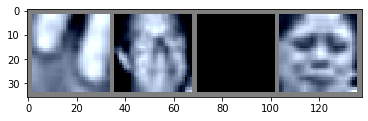

nonface  face nonface  face


In [16]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [18]:
for epoch in range(5): 
    learning_rate = 6e-6
    weight_decay =0.004167
    optimizer = torch.optim.SGD(model.parameters(),lr=learning_rate, weight_decay = weight_decay)
    
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        X = inputs.reshape(-1,inputSize)
        x = torch.tensor(X)
        y_pred = model(x)
        loss = criterion(y_pred,labels)
    
        loss.backward()
    
        optimizer.step()
        optimizer.zero_grad()
        
        running_loss += loss.item()
        if i % 200 == 199:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 200))
            running_loss = 0.0

print('Finished Training')

C:\Users\Rache\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # Remove the CWD from sys.path while we load stuff.


[1,   200] loss: 0.063
[1,   400] loss: 0.065
[2,   200] loss: 0.061
[2,   400] loss: 0.063
[3,   200] loss: 0.056
[3,   400] loss: 0.064
[4,   200] loss: 0.057
[4,   400] loss: 0.062
[5,   200] loss: 0.057
[5,   400] loss: 0.062
Finished Training


In [19]:
correct = 0
total = 0
with torch.no_grad():
    for data in trainloader:
        images, labels = data
        X = images.reshape(-1,inputSize)
        outputs = model(X)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 98 %


In [20]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        X = images.reshape(-1,inputSize)
        outputs = model(X)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy : %d %%' % (100 * correct / total))

Accuracy : 97 %


In [21]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        X = images.reshape(-1,inputSize)
        outputs = model(X)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

for i in range(2):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of  face : 96 %
Accuracy of nonface : 98 %


with regularization weight_rate

### Data Augmentation 

- Data augmentation is a strategy that enables practitioners to significantly increase the diversity of data available for training models, without actually collecting new data.
- Data augmentation techniques such as cropping, padding, and horizontal flipping are commonly used to train large neural networks. 

### Random Crops

In [22]:
from torchvision import transforms
from torchvision.transforms import RandomCrop
transforms = transforms.Compose([RandomCrop(20,20),
                                ToTensor(),
                                Normalize([0.485,0.456,0.406],[0.229,0.2245,0.225])
                               ])

In [23]:
trainset = torchvision.datasets.ImageFolder(root=os.path.join(root_dir,'train_dir'),
                                            transform=transforms)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

In [24]:
trainset

Dataset ImageFolder
    Number of datapoints: 2000
    Root location: ./main_dir\train_dir
    StandardTransform
Transform: Compose(
               RandomCrop(size=(20, 20), padding=20)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.2245, 0.225])
           )

In [25]:
from torchvision import transforms
transforms = transforms.Compose([Resize((20,20)),
                                 ToTensor(),
                                 Normalize([0.485,0.456,0.406],[0.229,0.2245,0.225])])

In [26]:
testset = torchvision.datasets.ImageFolder(root=os.path.join(root_dir,'test_dir'), 
                                           transform=transforms)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

In [27]:
classes = ('face','nonface')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


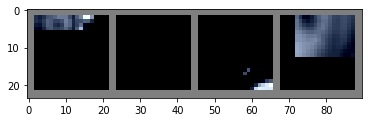

 face nonface  face nonface


In [28]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


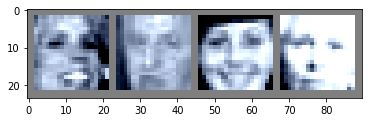

 face  face  face  face


In [29]:
# get some random training images
dataiter = iter(testloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [30]:
inputSize = 20*20*3
outputSize = 2
hiddenSize = 10

In [31]:
from torch import nn
model = torch.nn.Sequential(
    torch.nn.Linear(inputSize,hiddenSize),
    torch.nn.ReLU(),
    torch.nn.Linear(hiddenSize,outputSize),
    torch.nn.LogSoftmax(dim=1))
print(model)

Sequential(
  (0): Linear(in_features=1200, out_features=10, bias=True)
  (1): ReLU()
  (2): Linear(in_features=10, out_features=2, bias=True)
  (3): LogSoftmax()
)


In [44]:
for epoch in range(5): 
    learning_rate = 1e-2
    optimizer = torch.optim.SGD(model.parameters(),lr=learning_rate, weight_decay=0.01)
    
    running_loss = 0.0
    #running_accuracy = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        X = inputs.reshape(-1,inputSize)
        x = torch.tensor(X)
        y_pred = model(x)
        loss = criterion(y_pred,labels)
    
        loss.backward()
    
        optimizer.step()
        optimizer.zero_grad()
        
        running_loss += loss.item()
        #running_accuracy +=acc.item()
        if i % 200 == 199:    # print every 2000 mini-batches
            print(f'(epoch: {epoch + 1}, {running_loss / 200:.2f})')
            running_loss = 0.0

print('Finished Training')

C:\Users\Rache\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # Remove the CWD from sys.path while we load stuff.


(epoch: 1, 0.74)
(epoch: 1, 0.70)
(epoch: 2, 0.71)
(epoch: 2, 0.71)
(epoch: 3, 0.69)
(epoch: 3, 0.69)
(epoch: 4, 0.69)
(epoch: 4, 0.69)
(epoch: 5, 0.69)
(epoch: 5, 0.69)
Finished Training


In [45]:
correct = 0
total = 0
with torch.no_grad(): # we dont use back propagation during interference
    for data in testloader:
        images, labels = data
        X = images.reshape(-1,inputSize)
        outputs = model(X)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy : %d %%' % (100 * correct / total))

Accuracy : 57 %


In [46]:
class_correct = list(0. for i in range(2))
class_total = list(0. for i in range(2))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        X = images.reshape(-1,inputSize)
        outputs = model(X)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(2):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of  face : 86 %
Accuracy of nonface : 28 %


### Horizontal Flip

In [47]:
from torchvision import transforms
transforms = transforms.Compose([Resize((32,32)),
                                 transforms.RandomHorizontalFlip(),
                                 ToTensor(),
                                 Normalize([0.485,0.456,0.406],[0.229,0.2245,0.225])])

In [48]:
trainset = torchvision.datasets.ImageFolder(root=os.path.join(root_dir,'train_dir'),
                                            transform=transforms)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

In [49]:
from torchvision import transforms
transforms = transforms.Compose([Resize((32,32)),
                                 ToTensor(),
                                 Normalize([0.485,0.456,0.406],[0.229,0.2245,0.225])])

In [50]:
testset = torchvision.datasets.ImageFolder(root=os.path.join(root_dir,'test_dir'), 
                                           transform=transforms)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

In [51]:
classes = ('face','nonface')

In [52]:
inputSize = 32*32*3
outputSize = 2
hiddenSize = 10

In [53]:
from torch import nn
model = torch.nn.Sequential(
    torch.nn.Linear(inputSize,hiddenSize),
    torch.nn.ReLU(),
    torch.nn.Linear(hiddenSize,outputSize),
    torch.nn.LogSoftmax(dim=1))
print(model)

Sequential(
  (0): Linear(in_features=3072, out_features=10, bias=True)
  (1): ReLU()
  (2): Linear(in_features=10, out_features=2, bias=True)
  (3): LogSoftmax()
)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


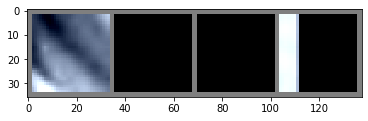

nonface nonface nonface nonface


In [54]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [56]:
for epoch in range(5): 
    learning_rate = 6e-6
    optimizer = torch.optim.SGD(model.parameters(),lr=learning_rate, weight_decay=0.004167)
    
    running_loss = 0.0
    #running_accuracy = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        X = inputs.reshape(-1,inputSize)
        x = torch.tensor(X)
        y_pred = model(x)
        loss = criterion(y_pred,labels)
    
        loss.backward()
    
        optimizer.step()
        optimizer.zero_grad()
        
        running_loss += loss.item()
        #running_accuracy +=acc.item()
        if i % 200 == 199:    # print every 2000 mini-batches
            print(f'(epoch: {epoch + 1}, {running_loss / 200:.2f})')
            running_loss = 0.0

print('Finished Training')

C:\Users\Rache\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # Remove the CWD from sys.path while we load stuff.


(epoch: 1, 0.08)
(epoch: 1, 0.07)
(epoch: 2, 0.09)
(epoch: 2, 0.07)
(epoch: 3, 0.09)
(epoch: 3, 0.07)
(epoch: 4, 0.08)
(epoch: 4, 0.08)
(epoch: 5, 0.07)
(epoch: 5, 0.07)
Finished Training


In [57]:
correct = 0
total = 0
with torch.no_grad(): # we dont use back propagation during interference
    for data in testloader:
        images, labels = data
        X = images.reshape(-1,inputSize)
        outputs = model(X)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy : %d %%' % (100 * correct / total))

Accuracy : 97 %


In [58]:
class_correct = list(0. for i in range(2))
class_total = list(0. for i in range(2))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        X = images.reshape(-1,inputSize)
        outputs = model(X)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(2):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of  face : 96 %
Accuracy of nonface : 99 %


### Architecture Selection

In [59]:
inputSize = 32*32*3
hiddenSize_1 = 100
hiddenSize_2 = 50 
outputSize = 2

In [60]:
from torch import nn
model = torch.nn.Sequential(
    torch.nn.Linear(inputSize,hiddenSize_1),
    torch.nn.ReLU(),
    torch.nn.Linear(hiddenSize_1,hiddenSize_2),
    torch.nn.ReLU(),
    torch.nn.Linear(hiddenSize_2,outputSize),
    torch.nn.LogSoftmax(dim=1))
print(model)

Sequential(
  (0): Linear(in_features=3072, out_features=100, bias=True)
  (1): ReLU()
  (2): Linear(in_features=100, out_features=50, bias=True)
  (3): ReLU()
  (4): Linear(in_features=50, out_features=2, bias=True)
  (5): LogSoftmax()
)


In [64]:
for epoch in range(5): 
    learning_rate = 6e-6
    optimizer = torch.optim.SGD(model.parameters(),lr=learning_rate, weight_decay=0.004167)
    
    running_loss = 0.0
    #running_accuracy = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        X = inputs.reshape(-1,inputSize)
        x = torch.tensor(X)
        y_pred = model(x)
        loss = criterion(y_pred,labels)
    
        loss.backward()
    
        optimizer.step()
        optimizer.zero_grad()
        
        running_loss += loss.item()
        #running_accuracy +=acc.item()
        if i % 200 == 199:    # print every 2000 mini-batches
            print(f'(epoch: {epoch + 1}, {running_loss / 200:.2f})')
            running_loss = 0.0

print('Finished Training')

C:\Users\Rache\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # Remove the CWD from sys.path while we load stuff.


(epoch: 1, 0.09)
(epoch: 1, 0.09)
(epoch: 2, 0.09)
(epoch: 2, 0.09)
(epoch: 3, 0.09)
(epoch: 3, 0.09)
(epoch: 4, 0.09)
(epoch: 4, 0.09)
(epoch: 5, 0.08)
(epoch: 5, 0.10)
Finished Training


In [65]:
correct = 0
total = 0
with torch.no_grad(): # we dont use back propagation during interference
    for data in testloader:
        images, labels = data
        X = images.reshape(-1,inputSize)
        outputs = model(X)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy : %d %%' % (100 * correct / total))

Accuracy : 97 %


In [66]:
class_correct = list(0. for i in range(2))
class_total = list(0. for i in range(2))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        X = images.reshape(-1,inputSize)
        outputs = model(X)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(2):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of  face : 97 %
Accuracy of nonface : 98 %


In [69]:
inputSize = 32*32*3
hiddenSize_1 = 100
hiddenSize_2 = 10 
outputSize = 10

In [70]:
from torch import nn
model = torch.nn.Sequential(
    torch.nn.Linear(inputSize,hiddenSize_1),
    torch.nn.ReLU(),
    torch.nn.Linear(hiddenSize_1,hiddenSize_2),
    torch.nn.ReLU(),
    torch.nn.Linear(hiddenSize_2,outputSize),
    torch.nn.LogSoftmax(dim=1))
print(model)

Sequential(
  (0): Linear(in_features=3072, out_features=100, bias=True)
  (1): ReLU()
  (2): Linear(in_features=100, out_features=10, bias=True)
  (3): ReLU()
  (4): Linear(in_features=10, out_features=10, bias=True)
  (5): LogSoftmax()
)


In [71]:
import torchvision.transforms as transforms
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [76]:
for epoch in range(5): 
    learning_rate = 6e-6
    optimizer = torch.optim.SGD(model.parameters(),lr=learning_rate, weight_decay=0.004167)
    
    running_loss = 0.0
    #running_accuracy = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        X = inputs.reshape(-1,inputSize)
        x = torch.tensor(X)
        y_pred = model(x)
        loss = criterion(y_pred,labels)
    
        loss.backward()
    
        optimizer.step()
        optimizer.zero_grad()
        
        running_loss += loss.item()
        #running_accuracy +=acc.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'(epoch: {epoch + 1}, {running_loss / 2000:.2f})')
            running_loss = 0.0

print('Finished Training')

C:\Users\Rache\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # Remove the CWD from sys.path while we load stuff.


(epoch: 1, 1.73)
(epoch: 1, 1.71)
(epoch: 1, 1.71)
(epoch: 1, 1.68)
(epoch: 1, 1.65)
(epoch: 1, 1.65)
(epoch: 2, 1.65)
(epoch: 2, 1.60)
(epoch: 2, 1.59)
(epoch: 2, 1.61)
(epoch: 2, 1.57)
(epoch: 2, 1.56)
(epoch: 3, 1.55)
(epoch: 3, 1.54)
(epoch: 3, 1.54)
(epoch: 3, 1.52)
(epoch: 3, 1.53)
(epoch: 3, 1.51)
(epoch: 4, 1.49)
(epoch: 4, 1.48)
(epoch: 4, 1.48)
(epoch: 4, 1.48)
(epoch: 4, 1.48)
(epoch: 4, 1.46)
(epoch: 5, 1.44)
(epoch: 5, 1.44)
(epoch: 5, 1.46)
(epoch: 5, 1.43)
(epoch: 5, 1.43)
(epoch: 5, 1.42)
Finished Training


In [77]:
correct = 0
total = 0
with torch.no_grad(): # we dont use back propagation during interference
    for data in testloader:
        images, labels = data
        X = images.reshape(-1,inputSize)
        outputs = model(X)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy : %d %%' % (100 * correct / total))

Accuracy : 48 %


In [78]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        X = images.reshape(-1,inputSize)
        outputs = model(X)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 56 %
Accuracy of   car : 62 %
Accuracy of  bird : 31 %
Accuracy of   cat : 29 %
Accuracy of  deer : 34 %
Accuracy of   dog : 38 %
Accuracy of  frog : 59 %
Accuracy of horse : 56 %
Accuracy of  ship : 64 %
Accuracy of truck : 52 %


Different Model requires different learning rate and weight_decay 

In [79]:
for epoch in range(2): 
    learning_rate = 1e-2
    optimizer = torch.optim.SGD(model.parameters(),lr=learning_rate, weight_decay=1e-6)
    
    running_loss = 0.0
    #running_accuracy = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        X = inputs.reshape(-1,inputSize)
        x = torch.tensor(X)
        y_pred = model(x)
        loss = criterion(y_pred,labels)
    
        loss.backward()
    
        optimizer.step()
        optimizer.zero_grad()
        
        running_loss += loss.item()
        #running_accuracy +=acc.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'(epoch: {epoch + 1}, {running_loss / 2000:.2f})')
            running_loss = 0.0

print('Finished Training')

C:\Users\Rache\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # Remove the CWD from sys.path while we load stuff.


(epoch: 1, 1.62)
(epoch: 1, 1.59)
(epoch: 1, 1.55)
(epoch: 1, 1.54)
(epoch: 1, 1.54)
(epoch: 1, 1.52)
(epoch: 2, 1.45)
(epoch: 2, 1.47)
(epoch: 2, 1.44)
(epoch: 2, 1.48)
(epoch: 2, 1.44)
(epoch: 2, 1.45)
Finished Training


In [80]:
correct = 0
total = 0
with torch.no_grad(): # we dont use back propagation during interference
    for data in testloader:
        images, labels = data
        X = images.reshape(-1,inputSize)
        outputs = model(X)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy : %d %%' % (100 * correct / total))

Accuracy : 47 %


In [81]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        X = images.reshape(-1,inputSize)
        outputs = model(X)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 47 %
Accuracy of   car : 39 %
Accuracy of  bird : 27 %
Accuracy of   cat : 43 %
Accuracy of  deer : 48 %
Accuracy of   dog : 27 %
Accuracy of  frog : 53 %
Accuracy of horse : 51 %
Accuracy of  ship : 67 %
Accuracy of truck : 68 %
